# Lab1 - AI - Neural networks for digit recognition

**R4.A.13 - BUT2 - IUT Vannes**


## Introduction

In this lab, we will build and train a neural network for digit recognition from the MNIST dataset. We will use the **nn** module of Pytorch.

This lab was prepared based on the tutorial: (https://datahacker.rs/mnist-handwritten-digit-recognition-in-pytorch-1-3/)

Please note that the implementation from the tutorial needs to be adapted and corrected. A simple copy/paste will not work.


**Setting up the environment**


In [1]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [2]:
# what is your GPU ?
!nvidia-smi


'nvidia-smi' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


### **1. Loading MNIST dataset from torchvision**

In [3]:
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

# Download and load the training data and the validation (test) data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)


**---------------Question 1---------------**

*   What is the role of *transforms.ToTensor()* ?

The role of `transforms.ToTensor()` is to convert PIL Images or NumPy arrays representing images into PyTorch tensors. It automatically scales the images' pixel intensity values from the range [0, 255] to the floating-point values in the range [0.0, 1.0]. This transformation is crucial for preparing the image data for processing by neural networks in PyTorch, ensuring that the data is in the correct format and scale for training.

*   What is the role of *transforms.Normalize()* ? What are the values 0.1307 and 0.3081 ?

The role of `transforms.Normalize()` is to normalize the tensor image with mean and standard deviation. Given mean: `(0.1307,)` and std: `(0.3081,)`, this transformation normalizes each channel of the input tensor. Specifically, for the MNIST dataset, it subtracts 0.1307 from each pixel and then divides the result by 0.3081. This normalization helps in stabilizing the learning process and significantly reduces the number of training epochs required to train deep learning models. The values 0.1307 and 0.3081 are the global mean and standard deviation of the MNIST dataset, ensuring that the input features are more consistent and potentially speeding up the convergence during training.

*   What is the batch size 64 ?

The batch size of 64 refers to the number of training examples utilized in one iteration of model training. In this context, the DataLoader will load 64 images and their corresponding labels at once to pass through the neural network for each training step. This size is a compromise between training speed and the accuracy of the gradient estimation. A batch size of 64 is a common choice, providing a good balance between the computational efficiency of processing batches and the stochastic nature of mini-batch gradient descent.


In [4]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))


Train size :  60000
validation size :  10000


In [5]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels


torch.Size([64, 1, 28, 28])
torch.Size([64])


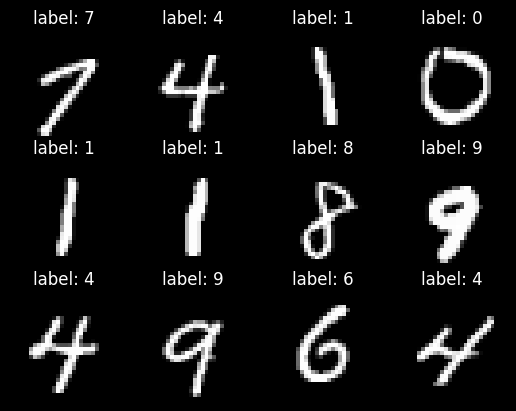

In [6]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray'); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))


**---------------Question 2---------------**

*   What is the role of *numpy()* ?

The `numpy()` function is used to convert PyTorch tensors into NumPy arrays. This conversion is necessary because certain operations or libraries, like Matplotlib for plotting, work with NumPy arrays rather than PyTorch tensors. It's a bridge between the two libraries, allowing data to be manipulated or visualized using the extensive toolkit available in NumPy.

*   What is the role of *squeeze()* ?

The `squeeze()` function is used to remove all of the dimensions of input size 1 from the tensor, thereby reducing the dimensionality of the tensor without changing its data. For example, if the tensor has a shape of `(64, 1, 28, 28)` (representing batch size, channels, height, and width), applying squeeze() to the tensor would remove the single-channel dimension, resulting in a shape of `(64, 28, 28)`. This operation is useful for removing unnecessary dimensions that might complicate tensor operations or visualizations.


In [7]:
# check the function squeeze()

print(images[i].numpy().squeeze().shape)


(28, 28)


### **2. Build a fully-connected neural network**

Let's define a **2-layer neural network** with:
- first layer: 128 neurons
- second layer: 256 neurons
- activation ReLu
- do not use *dropout* layer (as proposed in the tutorial) for the moment

In [8]:
"""
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t
"""

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # MNIST images are 28x28 pixels, so the input size is 784
        self.input_size = 28 * 28
        self.output_size = 10  # There are 10 classes (digits 0-9)

        # Define the first fully connected layer
        self.fc1 = nn.Linear(self.input_size, 128)
        # Define the second fully connected layer
        self.fc2 = nn.Linear(128, 256)
        # Define the output layer
        self.fc3 = nn.Linear(256, self.output_size)

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(-1, self.input_size)
        # First fully connected layer with ReLU activation function
        x = F.relu(self.fc1(x))
        # Second fully connected layer with ReLU activation function
        x = F.relu(self.fc2(x))
        # Output layer
        x = self.fc3(x)
        return x


Let's now initialize the network

In [9]:
"""
# Create an instance of the network
network = Network()
network.to(device)

# Define the loss function and the optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)

# Train the network
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

# Test the network on the validation data
correct = 0
total = 0
with torch.no_grad():
    for data in validationLoader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
"""

# Instantiate the network
model = Network()

# Move the model to the device (GPU or CPU)
model.to(device)

print(model)


Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


**---------------Question 3---------------**

*   Cacluate the total number of parameters ?
*   How to print the total number of trainable parameters in Pytorch ?

In [10]:
# print number of total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Total number of trainable parameters: 136074


### **3. Train the model**

Let's set up the optimizer and the loss function. You can use the Stochastic **Gradient Descent optimizer (SGD)** and the **Cross-entropy** loss as proposed by the tutorial.

In [11]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)


Now train and evaluate/validate the model (during the training)

In [12]:
epochs = 10
train_losses, validation_losses = [], []
train_accuracies, validation_accuracies = [], []

for epoch in range(epochs):
    running_loss = 0
    correct = 0
    total = 0
    
    model.train()  # Set the model to training mode
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_losses.append(running_loss / len(trainLoader))
    train_accuracies.append(correct / total)
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in validationLoader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    validation_losses.append(validation_loss / len(validationLoader))
    validation_accuracies.append(correct / total)
    
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_losses[-1]:.3f}.. "
          f"Train accuracy: {train_accuracies[-1]:.3f}.. "
          f"Validation loss: {validation_losses[-1]:.3f}.. "
          f"Validation accuracy: {validation_accuracies[-1]:.3f}")


Epoch 1/10.. Train loss: 0.746.. Train accuracy: 0.810.. Validation loss: 0.326.. Validation accuracy: 0.906
Epoch 2/10.. Train loss: 0.301.. Train accuracy: 0.913.. Validation loss: 0.255.. Validation accuracy: 0.926
Epoch 3/10.. Train loss: 0.246.. Train accuracy: 0.928.. Validation loss: 0.219.. Validation accuracy: 0.937
Epoch 4/10.. Train loss: 0.209.. Train accuracy: 0.940.. Validation loss: 0.192.. Validation accuracy: 0.943
Epoch 5/10.. Train loss: 0.183.. Train accuracy: 0.948.. Validation loss: 0.171.. Validation accuracy: 0.949
Epoch 6/10.. Train loss: 0.162.. Train accuracy: 0.953.. Validation loss: 0.155.. Validation accuracy: 0.955
Epoch 7/10.. Train loss: 0.146.. Train accuracy: 0.958.. Validation loss: 0.143.. Validation accuracy: 0.958
Epoch 8/10.. Train loss: 0.132.. Train accuracy: 0.962.. Validation loss: 0.133.. Validation accuracy: 0.959
Epoch 9/10.. Train loss: 0.120.. Train accuracy: 0.965.. Validation loss: 0.125.. Validation accuracy: 0.964
Epoch 10/10.. Train

Let’s plot our loss and accuracies and see if they are falling or growing.



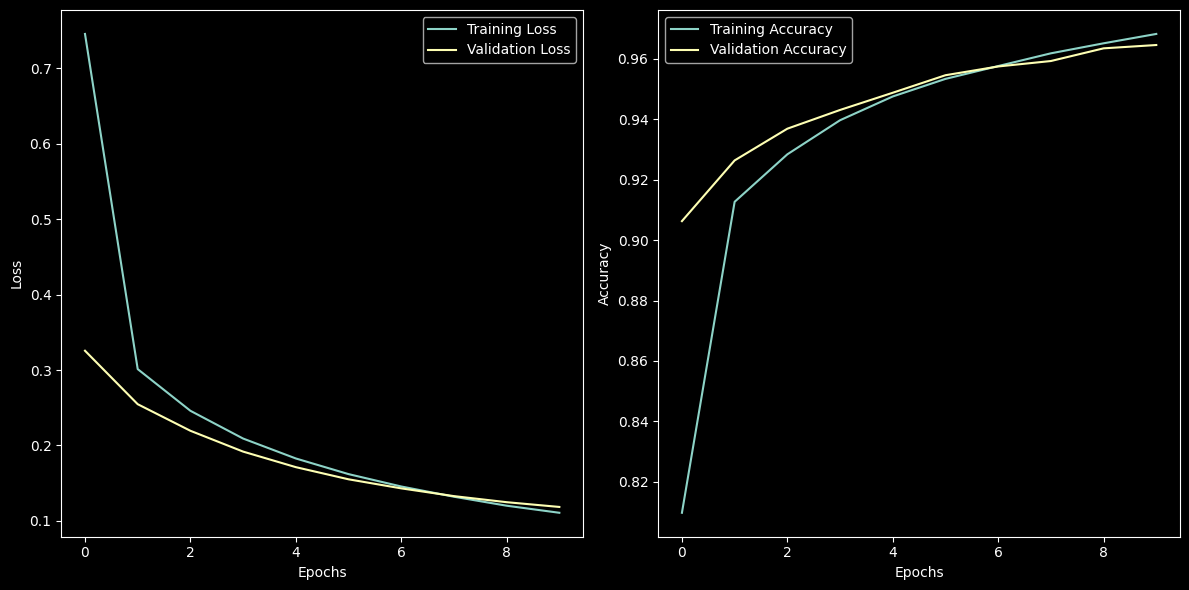

In [13]:
# plot the loss curves and accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



**---------------Question 4---------------**

*  Your remarks and comments about the training process ?

1. **Batch processing** : The use of mini-batch gradient descent (via DataLoader with a specified batch size) is effective for managing memory resources and accelerating the training process. It strikes a balance between the computational efficiency of batch gradient descent and the stochastic nature of SGD.
2. **Learning rate and optimizer** : The choice of SGD and a learning rate of 0.01 is a standard starting point, but the training process could potentially benefit from a learning rate schedule (e.g., reducing the learning rate when a metric has stopped improving) or using more sophisticated optimizers like Adam, which can adapt the learning rates of each parameter.
3. **Evaluation during training** : Evaluating the model on a validation set during training is crucial for monitoring overfitting. If the training accuracy continues to improve while the validation accuracy plateaus or decreases, it could indicate that the model is beginning to memorize the training data rather than learning generalizable patterns.
4. **Loss and accuracy trends** : The trends in loss and accuracy on both training and validation sets give important feedback about the learning process. Ideally, both training and validation losses should decrease over time, and accuracies should increase. Plateaus or increases in loss or decreases in accuracy could indicate issues such as learning rate problems or model complexity issues.

*  Why is the training time of the first epoch is so long ?
1. **Initialization overhead** : At the beginning of the training process, there's some one-time setup work that needs to be done, including allocating memory for the model's parameters, initializing the data loaders, and transferring the initial batch of data to the GPU if one is being used. This overhead is only incurred once, making the first epoch take longer than subsequent ones.
2. **Caching effects** : When data is loaded for the first time, it may also be cached in memory, making access faster for subsequent epochs. The initial loading and processing of data can contribute to a longer first epoch.
3. **Compilation overhead** : In some deep learning frameworks and hardware setups (especially when using GPUs), the first invocation of the model's forward and backward passes might trigger compilation of computational graphs or kernels. This compilation is a one-time cost that makes the first epoch longer.
4. **Data loading and augmentation** : If there's significant data preprocessing or augmentation happening on the fly during the data loading phase, this could also make the initial epochs slower as caches and optimizations haven't yet taken full effect.


### **4. Evaluation of a trained network**

Once our model is trained, we can simply use the trained weights to make some new predictions by turning off the gradients.

Let's first predict label for a single image.

In [14]:
model.eval()  # Set the model to evaluation mode

# Get one batch from the validation loader
images, labels = next(iter(validationLoader))
images, labels = images.to(device), labels.to(device)

# Take the first image from the batch
img = images[0].unsqueeze(0)  # Model expects a batch, so add batch dimension

with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    output = model(img)
    _, predicted_label = torch.max(output, 1)

# Convert the predicted label tensor to a numpy array and print it
print(f"Predicted Label: {predicted_label.item()}")


Predicted Label: 9


Predict labels for a batch

In [15]:
with torch.no_grad():
    outputs = model(images)  # Here, 'images' is a batch from the validation set
    _, predicted_labels = torch.max(outputs, 1)

# Print the predicted labels and the true labels
print(f"Predicted Labels: {predicted_labels}")
print(f"True Labels: {labels}")


Predicted Labels: tensor([9, 2, 3, 9, 1, 3, 9, 8, 5, 6, 0, 0, 5, 2, 3, 8, 4, 3, 4, 7, 9, 7, 3, 4,
        0, 1, 8, 7, 8, 9, 1, 5, 5, 6, 2, 1, 6, 6, 1, 9, 9, 6, 2, 5, 2, 3, 1, 0,
        2, 0, 3, 6, 8, 0, 8, 8, 8, 7, 0, 7, 6, 3, 1, 0])
True Labels: tensor([9, 2, 3, 9, 1, 3, 9, 8, 5, 6, 0, 0, 5, 2, 3, 8, 4, 3, 4, 7, 9, 7, 3, 4,
        0, 1, 8, 7, 8, 9, 1, 5, 5, 6, 2, 1, 6, 6, 1, 9, 9, 6, 2, 5, 2, 3, 1, 0,
        2, 0, 3, 6, 8, 0, 8, 8, 8, 7, 0, 7, 6, 3, 1, 0])


Calculate the performance on the whole validation set

In [16]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in validationLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')


Accuracy of the network on the validation images: 96.46%


### **5. Building other neural networks**
Now, you can try other hyper-parameters to see the their influence on the performance.
You can also create and test other neural nets by adding more neurons, more layers.

Report the performance and comments on your work
  

In [17]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class ComplexNetwork(nn.Module):
    def __init__(self):
        super(ComplexNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 256)  # First layer with more neurons
        self.fc2 = nn.Linear(256, 512)  # Additional layer
        self.fc3 = nn.Linear(512, 128)  # Additional layer with reduced neurons, to avoid too many params
        self.fc4 = nn.Linear(128, 10)   # Output layer for 10 classes

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [19]:
# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = DataLoader(train_set, batch_size=64, shuffle=True)
validation_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationLoader = DataLoader(validation_set, batch_size=64, shuffle=True)

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexNetwork().to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 10
training_losses = []
validation_losses = []
for epoch in range(epochs):
    model.train()
    training_loss = 0
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
    
    # Validation
    validation_loss = 0
    model.eval()
    with torch.no_grad():
        for images, labels in validationLoader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            validation_loss += loss.item()
    
    training_losses.append(training_loss / len(trainLoader))
    validation_losses.append(validation_loss / len(validationLoader))
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {training_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}")


Epoch 1/10, Training Loss: 0.2255, Validation Loss: 0.1195
Epoch 2/10, Training Loss: 0.0946, Validation Loss: 0.0838
Epoch 3/10, Training Loss: 0.0701, Validation Loss: 0.0866
Epoch 4/10, Training Loss: 0.0533, Validation Loss: 0.0925
Epoch 5/10, Training Loss: 0.0495, Validation Loss: 0.0760
Epoch 6/10, Training Loss: 0.0374, Validation Loss: 0.0937
Epoch 7/10, Training Loss: 0.0341, Validation Loss: 0.0987
Epoch 8/10, Training Loss: 0.0286, Validation Loss: 0.1109
Epoch 9/10, Training Loss: 0.0240, Validation Loss: 0.1006
Epoch 10/10, Training Loss: 0.0260, Validation Loss: 0.0868


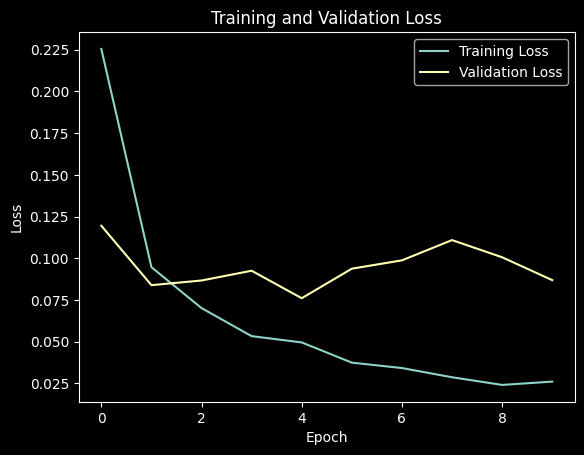

Final Training Loss: 0.0260
Final Validation Loss: 0.0868


In [20]:
# Plotting training and validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Final remarks on performance
print(f"Final Training Loss: {training_losses[-1]:.4f}")
print(f"Final Validation Loss: {validation_losses[-1]:.4f}")
